## INT2 Project
baseline from:
https://machinelearningmastery.com/how-to-develop-a-cnn-from-scratch-for-cifar-10-photo-classification/

In [1]:
#!unzip -q /content/gdrive/MyDrive/cifar10.zip -d /content/gdrive/MyDrive/

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.tensorboard import SummaryWriter
import time

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

cpu


In [3]:
#from torchvision.datasets.cifar import CIFAR10
TRAIN_DATA_PATH = "/content/gdrive/MyDrive/cifar10/train"
TEST_DATA_PATH = "/content/gdrive/MyDrive/cifar10/test"

transform = transforms.Compose(
    [transforms.AutoAugment(),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
#transform = transforms.Compose(
#    [transforms.ToTensor(),
#     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 16

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


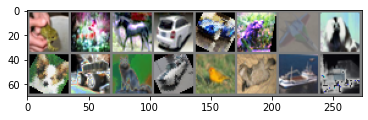

frog  deer  horse car   car   frog  plane dog   dog   truck cat   car   bird  cat   ship  truck


In [4]:

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imgGrid = torchvision.utils.make_grid(images)
imshow(imgGrid)
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [5]:
writer = SummaryWriter("runs/new-VGG16") #good one?
#tensorboard --logdir runs/testValidationError
writer.add_image("four images", imgGrid)
writer.flush()

In [6]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 64, 5)
        self.bn1 = nn.BatchNorm2d(64)
        self.drop1 = nn.Dropout(0.2),
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(64, 128, 5)
        self.bn2 = nn.BatchNorm2d(128)
        self.drop2 = nn.Dropout(0.3),
        self.fc1 = nn.Linear(128 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.drop1(x)
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.drop2(x)
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()

In [7]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9, weight_decay=0.001)

In [8]:
print(len(testloader))
print(len(trainloader))
start_time = time.time()
for epoch in range(30):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 1000 == 999:    # print every 1000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 1000:.3f} time: {time.time() - start_time}')
            # Check against the validation set
            running_vloss = 0.0

            net.train(False) # Don't need to track gradents for validation
            for j, vdata in enumerate(testloader, 0):
                vinputs, vlabels = vdata
                voutputs = net(vinputs)
                vloss = criterion(voutputs, vlabels)
                running_vloss += vloss.item()
            net.train(True) # Turn gradients back on for training

            avg_loss = running_loss / 1000
            avg_vloss = running_vloss / len(testloader)

            # Log the running loss averaged per batch
            writer.add_scalars('Training vs. Validation Loss',
                            { 'Training' : avg_loss, 'Validation' : avg_vloss },
                            epoch * len(trainloader) + i)
            running_loss = 0.0
    print(f'epoch time: {time.time() - start_time}')

print('Finished Training')

625
3125
[1,  1000] loss: 1.988 time: 39.70628237724304
[1,  2000] loss: 1.720 time: 89.76669096946716
[1,  3000] loss: 1.563 time: 139.0154571533203
epoch time: 155.5081343650818
[2,  1000] loss: 1.466 time: 193.38199877738953
[2,  2000] loss: 1.405 time: 238.73525762557983
[2,  3000] loss: 1.372 time: 283.55064392089844
epoch time: 298.5108993053436
[3,  1000] loss: 1.319 time: 339.0737268924713
[3,  2000] loss: 1.270 time: 386.1169853210449
[3,  3000] loss: 1.266 time: 433.76137590408325
epoch time: 449.28944516181946
[4,  1000] loss: 1.195 time: 488.064080953598
[4,  2000] loss: 1.206 time: 533.9012711048126
[4,  3000] loss: 1.165 time: 579.8150551319122
epoch time: 594.444979429245
[5,  1000] loss: 1.120 time: 632.4854934215546
[5,  2000] loss: 1.114 time: 680.0461883544922
[5,  3000] loss: 1.112 time: 726.0101590156555
epoch time: 740.4619936943054
[6,  1000] loss: 1.069 time: 778.6502773761749
[6,  2000] loss: 1.073 time: 823.6036128997803
[6,  3000] loss: 1.063 time: 868.774238

KeyboardInterrupt: 

In [9]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 69 %
